# Current and New Alignment Constants

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

## Alignment Constants
Load the table of alignment constants into memory and join them along the parameter IDs. We then deduce common categories from the parameter ID and then convert the parameter ID to a string for later plotting.

In [24]:
dets = [
    ('OG', pd.read_csv('from-pass2/HPS-PhysicsRun2016-Pass2-KF-FEEPC-iter0/local.csv')),
    ('+ 3 iter tu back st', pd.read_csv('from-pass2/HPS-PhysicsRun2016-Pass2-KF-FEEPC-iter3/local.csv')),
    ('+ 2 iter tu+rw back st', pd.read_csv('from-pass2/HPS-PhysicsRun2016-Pass2-KF-FEEPC-iter5/local.csv'))
]
for _name, df in dets :
    df['value'] = df.value.apply(pd.eval)
    # manual conversion from millepede ID into sensor/movement categories
    #     this was written for 2016 and will probably need to be updates for 2019/21
    df['top_bot'] = df.parameter // 10000
    df['t_r'] = (df.parameter % 10000) // 1000
    df['ax_st'] = (df.parameter % 2)
    df['u_v_w'] = (df.parameter % 1000) // 100
    df['mpii_module'] = (df.parameter % 100)
    df['individual'] = (df.mpii_module < 23) & (df.mpii_module > 0)
    df['layer'] = 1+(df.mpii_module < 9)*(df.mpii_module // 2)+(df.mpii_module >= 9)*(4+(df.mpii_module-9)//4)
    df.sort_values('parameter', inplace=True)

Now we can go through the different movement options for the individual sensors.

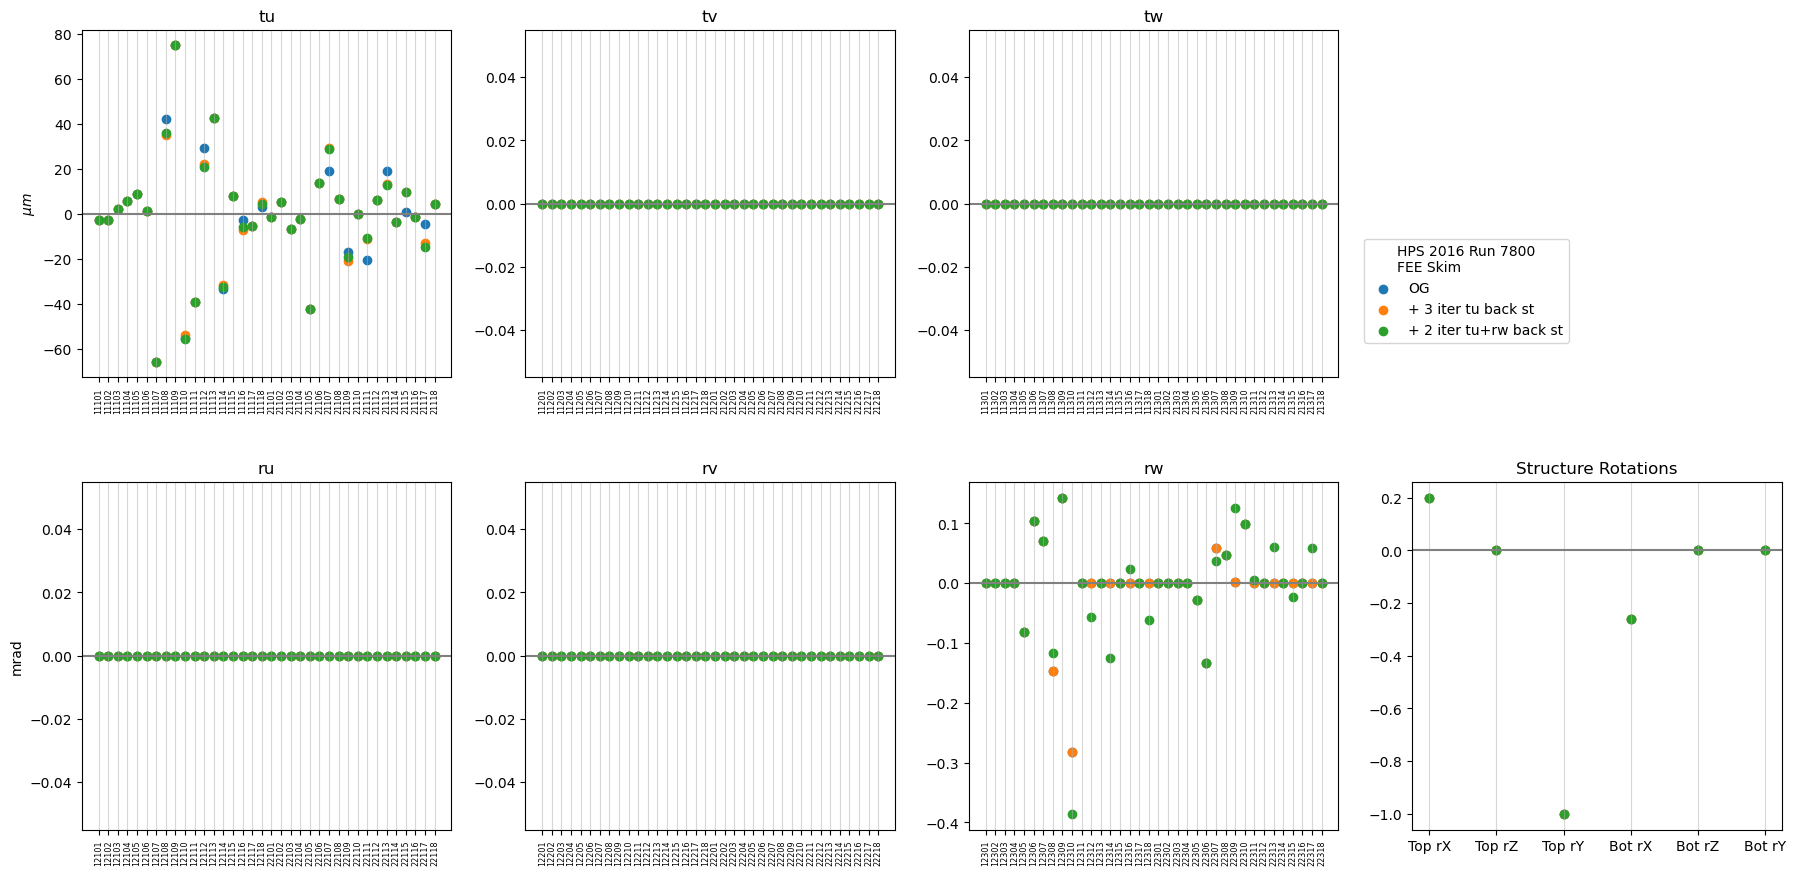

In [ ]:
fig, axes = plt.subplots(
    nrows=2,ncols=4,
    gridspec_kw = dict(
        wspace = 0.2,
        hspace = 0.3,
        bottom = 0,
        top = 1,
        left = 0,
        right = 1,
    )
)
fig.set_size_inches(17,8)

for tr, i_tr in [('t',1),('r',2)] :
    for uvw, i_uvw in [('u',1),('v',2),('w',3)] :
        ax = axes[i_tr-1][i_uvw-1]
        for name, df in dets :
            sl = (df.t_r == i_tr)&(df.u_v_w == i_uvw)
            ax.scatter(df[sl].parameter.apply(str), df[sl].value*1000, 
                       label=name if (i_tr == 1 and i_uvw == 1) else '_no_legend')
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), 
                      rotation=90, fontsize='xx-small')
        ax.grid(axis='x', alpha=0.5)
        ax.axhline(0., color='gray')
        ax.set_title(f'{tr}{uvw}')
        if i_uvw == 1 :
            if i_tr == 1 :
                ax.set_ylabel('$\mu m$')
            elif i_tr == 2 :
                ax.set_ylabel('mrad')

axes[0][-1].axis('off')

structure_labeling = {
    13100 : 'Top rX',
    13200 : 'Top rZ',
    13300 : 'Top rY',
    23100 : 'Bot rX',
    23200 : 'Bot rZ',
    23300 : 'Bot rY'
}

for name, df in dets :
    axes[1][-1].scatter(df[~df.individual].parameter.apply(lambda p : structure_labeling[p]),
                df[~df.individual].value*1000)
axes[1][-1].axhline(0., color='gray')
axes[1][-1].grid(axis='x', alpha=0.5)
axes[1][-1].set_title('Structure Rotations')

fig.legend(
    title = 'HPS 2016 Run 7800\nFEE Skim',
    loc='lower left',
    bbox_to_anchor=(0.75,0.6)
)
plt.show()

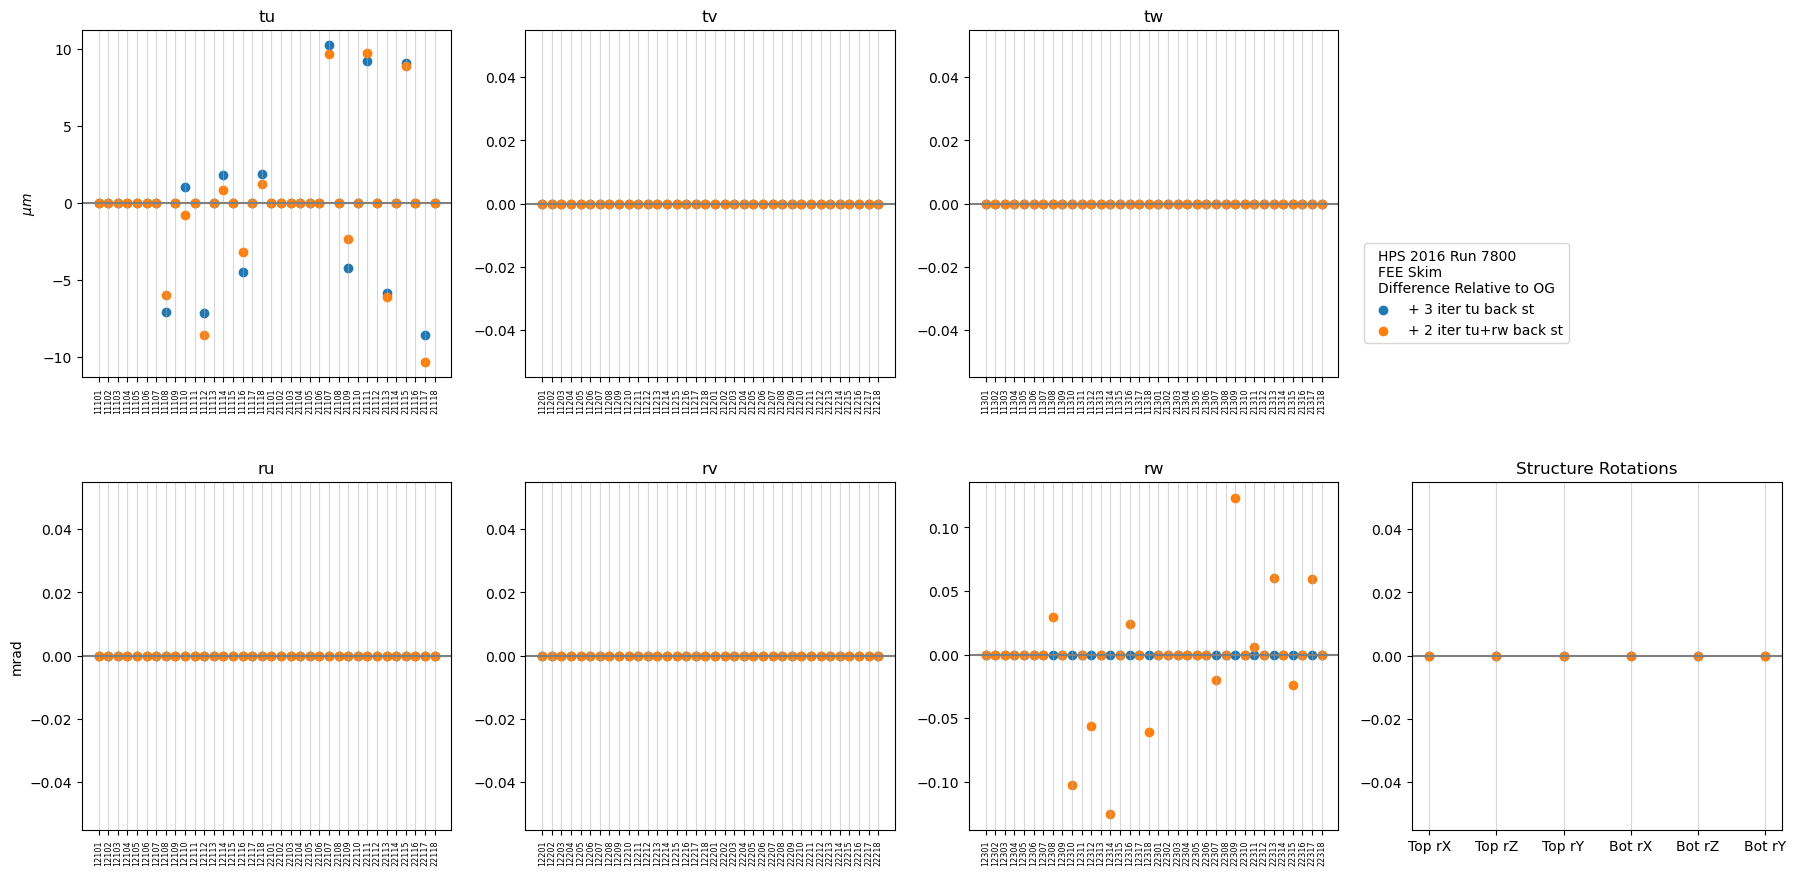

In [35]:
fig, axes = plt.subplots(
    nrows=2,ncols=4,
    gridspec_kw = dict(
        wspace = 0.2,
        hspace = 0.3,
        bottom = 0,
        top = 1,
        left = 0,
        right = 1,
    )
)
fig.set_size_inches(17,8)

for tr, i_tr in [('t',1),('r',2)] :
    for uvw, i_uvw in [('u',1),('v',2),('w',3)] :
        ax = axes[i_tr-1][i_uvw-1]
        for name, df in dets[1:] :
            sl = (df.t_r == i_tr)&(df.u_v_w == i_uvw)
            ax.scatter(df[sl].parameter.apply(str), (df[sl].value-dets[0][1][sl].value)*1000, 
                       label=name if (i_tr == 1 and i_uvw == 1) else '_no_legend')
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), 
                      rotation=90, fontsize='xx-small')
        ax.grid(axis='x', alpha=0.5)
        ax.axhline(0., color='gray')
        ax.set_title(f'{tr}{uvw}')
        if i_uvw == 1 :
            if i_tr == 1 :
                ax.set_ylabel('$\mu m$')
            elif i_tr == 2 :
                ax.set_ylabel('mrad')

axes[0][-1].axis('off')

structure_labeling = {
    13100 : 'Top rX',
    13200 : 'Top rZ',
    13300 : 'Top rY',
    23100 : 'Bot rX',
    23200 : 'Bot rZ',
    23300 : 'Bot rY'
}

for name, df in dets[1:] :
    axes[1][-1].scatter(df[~df.individual].parameter.apply(lambda p : structure_labeling[p]),
                (df[~df.individual].value-dets[0][1][~df.individual].value)*1000)
axes[1][-1].axhline(0., color='gray')
axes[1][-1].grid(axis='x', alpha=0.5)
axes[1][-1].set_title('Structure Rotations')

fig.legend(
    title = 'HPS 2016 Run 7800\nFEE Skim\nDifference Relative to OG',
    loc='lower left',
    bbox_to_anchor=(0.75,0.6)
)
plt.show()

## Global Position and Orientation
The dumps of the sensor positions and orientations can be dfared. I calculate some Euler angles from the u, v, w coordinate vectors in order to make the dfarison easier.

In [49]:
def euler_angles(u, v, w):
    theta_x = np.arctan2(v[2], w[2])
    theta_y = -np.arcsin(u[2])
    theta_z = np.arctan2(u[1], u[0])
    return [theta_x, theta_y, theta_z]

def load_json(f):
    df = pd.read_json(f).transpose()
    df['theta'] = df.apply(
        lambda row: euler_angles(row.u, row.v, row.w),
        axis=1
    )
    df = df.explode(df.columns.values.tolist())
    df['coord'] = df.groupby(level=0).cumcount().apply(
        lambda c: 'x' if c==0 else 'y' if c==1 else 'z'
    )
    for meas in ['position','u','v','w','theta']:
        df[meas] = df[meas].astype(float)
    df.reset_index(names='sensor', inplace=True)
    # shorten sensor name
    df['sensor'] = df.sensor.apply(lambda s: s.replace('module0_','').replace('_sensor0','').replace('halfmodule_','').replace('module_',''))
    return df.set_index(['coord','sensor'])

In [50]:
dets = {
    i : load_json(f'from-pass2/HPS-PhysicsRun2016-Pass2-KF-FEEPC-iter{i}/global.json')
    for i in [0,3,5]
}

In [51]:
def take_diff(d):
    # take difference between detectors, sort sensors by top/bottom, and drop ECalScoring planes
    diff = (
        d-dets[0]
    ).reset_index().sort_values(
        'sensor',
        key = lambda sensors: sensors.str.lower().apply(lambda s: '0'+s if 't_' in s else '1'+s if 'b_' in s and 'ECal' not in s else '2'+s),
    )
    diff.drop(
        diff[diff.sensor.str.contains('ECalScoring')].index,
        inplace=True
    )
    return diff

diffs = {
    name : take_diff(dets[i])
    for i, name in [(3,'3 iter tu back st'),(5,'+ 2 iter tu+rw back st')]
}

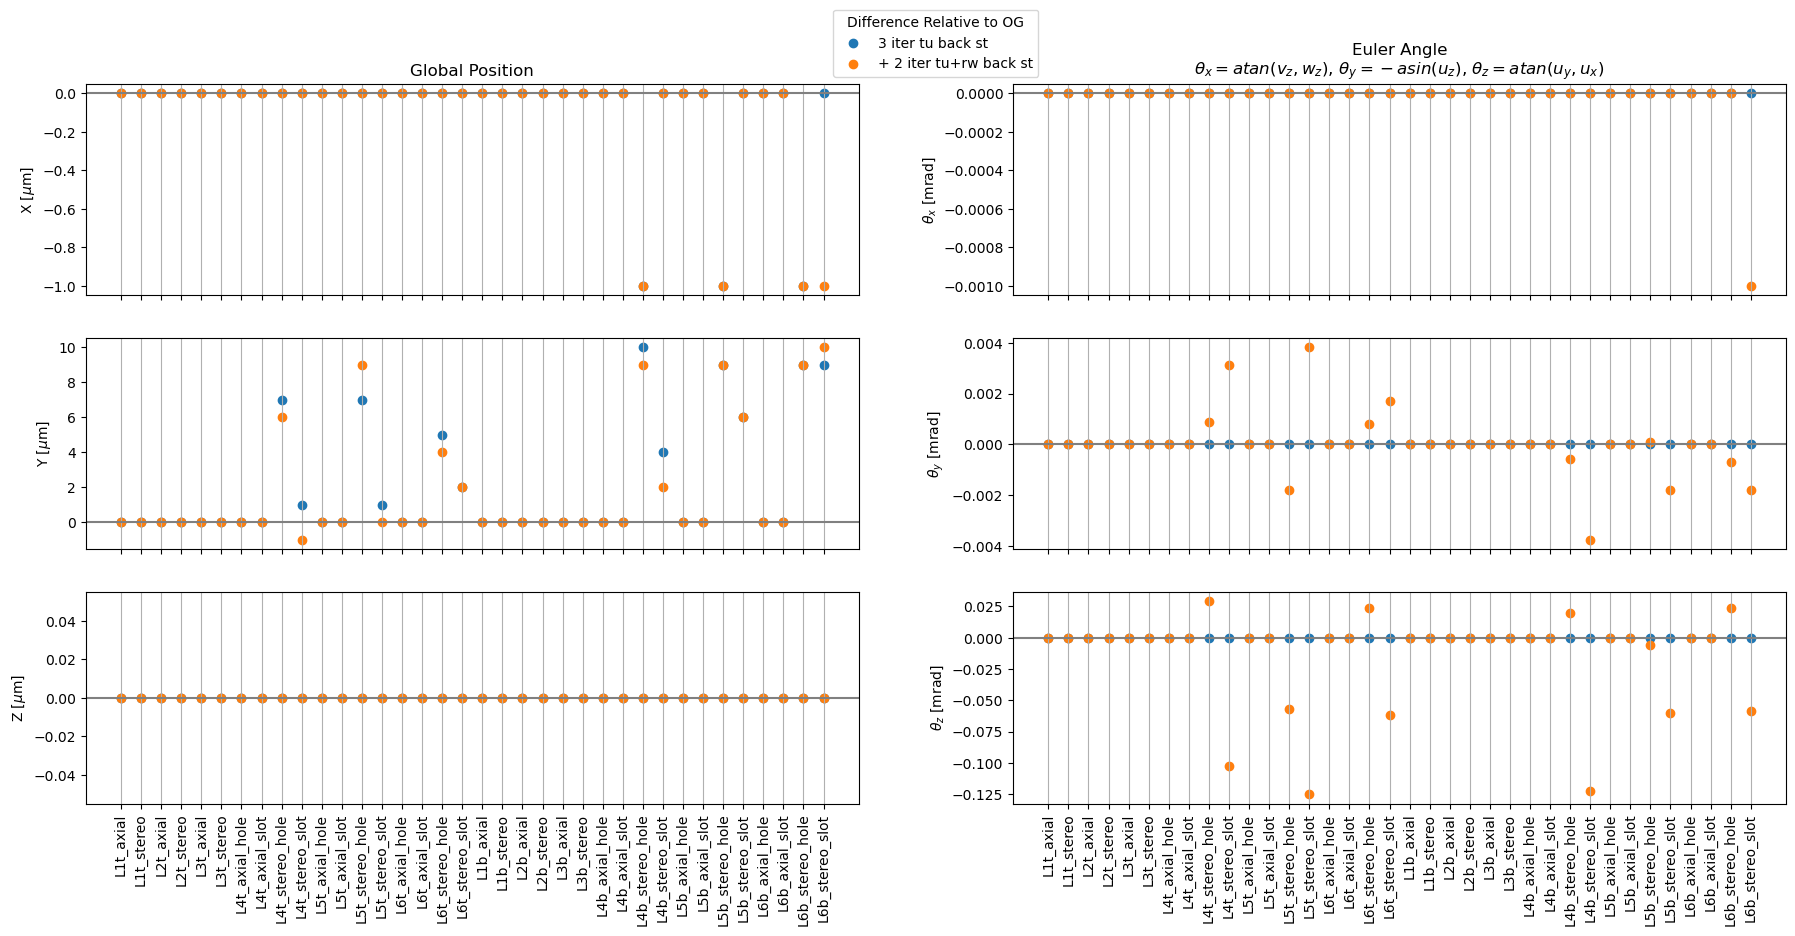

In [52]:
fig, axes = plt.subplots(
    nrows=3, ncols=2, sharex='col',
    gridspec_kw = dict(
        #wspace = 0.2,
        #hspace = 0.01,
        top=0.9,
        bottom=0,
        left=0,
        right=1,
    )
)
fig.set_size_inches(17,8)

for i_c, c in enumerate(['x','y','z']):
    for i_tr, tr in enumerate(['position','theta']):
        ax = axes[i_c][i_tr]
        for name, diff in diffs.items():
            ax.scatter(
                diff[diff.coord == c].sensor,
                diff[diff.coord == c][tr]*1000,
                label=name if i_c==0 and i_tr==0 else '_no_legend'
            )
        if tr == 'position':
            ax.set_ylabel(f'{c.upper()} [$\mu$m]')
        else:
            ax.set_ylabel(f'$\\theta_{c}$ [mrad]')
        ax.axhline(0.0, color='gray')
        ax.grid(axis='x')
        if c == 'x':
            if tr == 'position':
                ax.set_title('Global Position')
            else:
                ax.set_title('Euler Angle\n$\\theta_x = atan(v_z, w_z)$, $\\theta_y = -asin(u_z)$, $\\theta_z = atan(u_y, u_x)$')
        if c == 'z':
            ax.set_xticks(
                ax.get_xticks(),
                ax.get_xticklabels(),
                rotation=90
            )
fig.legend(
    title='Difference Relative to OG',
    loc='lower center',
    bbox_to_anchor=(0.5,0.9)
)
plt.show()